In [3]:
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

CUDA is not available.  Training on CPU ...


device(type='cpu')

In [4]:
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 64

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10, fill=(0,)),
    #transforms.RandomPerspective(),
    #transforms.RandomAffine(10),

    ])

transform_val = transforms.Compose([
    transforms.ToTensor(),

    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
val_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_val)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_val)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
#np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(), #1
            nn.Conv2d(16, 16, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(), #3
            nn.MaxPool2d(2, 2), #4
            nn.Conv2d(16, 32, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#6
            nn.Conv2d(32, 32, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#8
            nn.MaxPool2d(2, 2), #9
            nn.Conv2d(32, 64, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#11
            nn.Conv2d(64, 64, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#13
            nn.MaxPool2d(2, stride=(2,2)), #14
            nn.Conv2d(64, 128, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#16
            nn.Conv2d(128, 128, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),#18
            nn.AdaptiveAvgPool2d((1,1)),#19
            nn.Flatten(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.network(x)
        return x
# create a complete CNN
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [6]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           2,320
              ReLU-4           [-1, 16, 32, 32]               0
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
              ReLU-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
              ReLU-9           [-1, 32, 16, 16]               0
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
             ReLU-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
             ReLU-14             [-1, 6

In [16]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
lr = 0.001
weight_decay=0
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer_name = 'Adam'

In [ ]:
# number of epochs to train the model
n_epochs = 200
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    correct= 0
    total=0
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    cur_val_acc = correct / total
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy:{:.6f}'.format(
        epoch, train_loss, valid_loss,cur_val_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.h5')
        valid_loss_min = valid_loss



Epoch: 1 	Training Loss: 1222.887867 	Validation Loss: 275.038743 	Validation Accuracy:0.309400
Validation loss decreased (inf --> 275.038743).  Saving model ...
Epoch: 2 	Training Loss: 1034.257251 	Validation Loss: 237.602071 	Validation Accuracy:0.423600
Validation loss decreased (275.038743 --> 237.602071).  Saving model ...
Epoch: 3 	Training Loss: 902.590425 	Validation Loss: 210.785402 	Validation Accuracy:0.499500
Validation loss decreased (237.602071 --> 210.785402).  Saving model ...
Epoch: 4 	Training Loss: 826.858386 	Validation Loss: 196.452726 	Validation Accuracy:0.537900
Validation loss decreased (210.785402 --> 196.452726).  Saving model ...
Epoch: 5 	Training Loss: 773.238760 	Validation Loss: 194.532856 	Validation Accuracy:0.553100
Validation loss decreased (196.452726 --> 194.532856).  Saving model ...
Epoch: 6 	Training Loss: 735.678488 	Validation Loss: 187.062629 	Validation Accuracy:0.568300
Validation loss decreased (194.532856 --> 187.062629).  Saving model .

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load('model_cifar.h5'))
net.eval()
total=0
correct =0
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
test_acc = correct / total
print(test_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8271


In [7]:
#extract features of each layer
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
images, labels = iter(train_loader).next()
image_example = images
exact_list={f'network.{k}': str(v) for v, k in enumerate([0,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])}
device="cpu"
model = model.to(device)
feature_extractor = create_feature_extractor(model,exact_list)
x=feature_extractor(image_example)


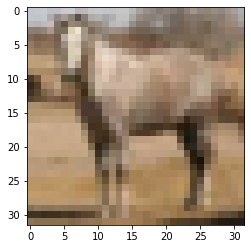

In [8]:
import matplotlib.pyplot as plt

images = image_example.numpy()
fig = plt.figure(figsize=(25, 4))
img=np.transpose(images[0], (1, 2, 0))
plt.imshow(img)

#train_examples = []
#for item in in_dict['train']:
#    in_tensor = torch.Tensor(item['input'])
#    out_tensor = torch.Tensor(item['output'])
#    train_examples.append([in_tensor, out_tensor])

In [9]:
layers=['0','2','3','5','7','8','10','12','13','15','17','18']

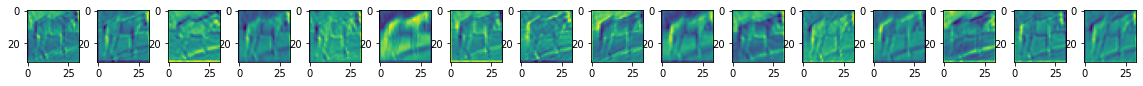

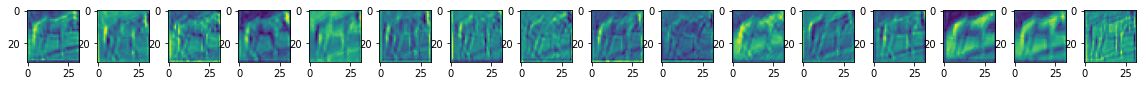

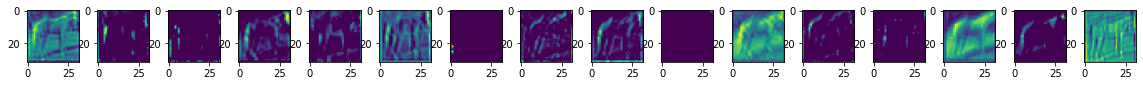

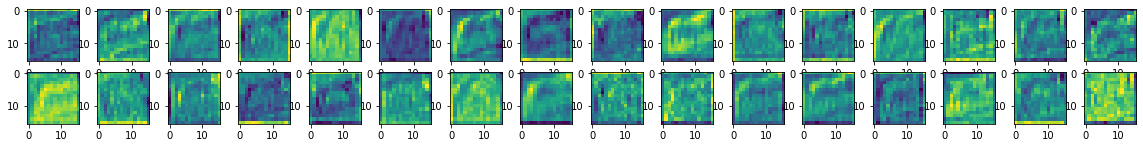

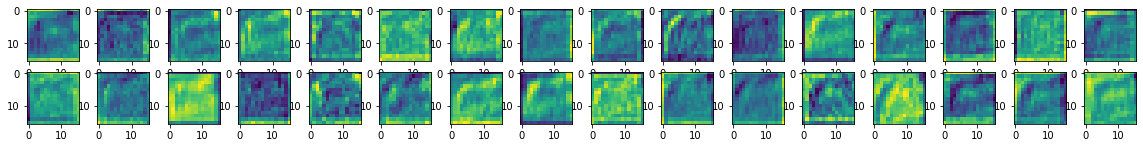

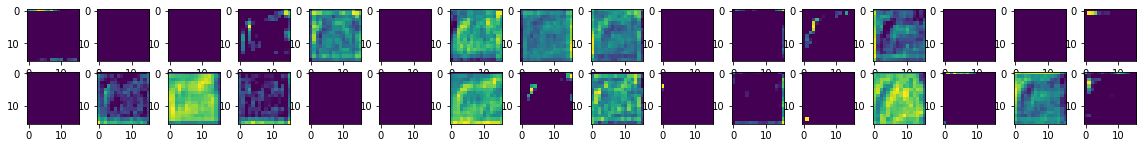

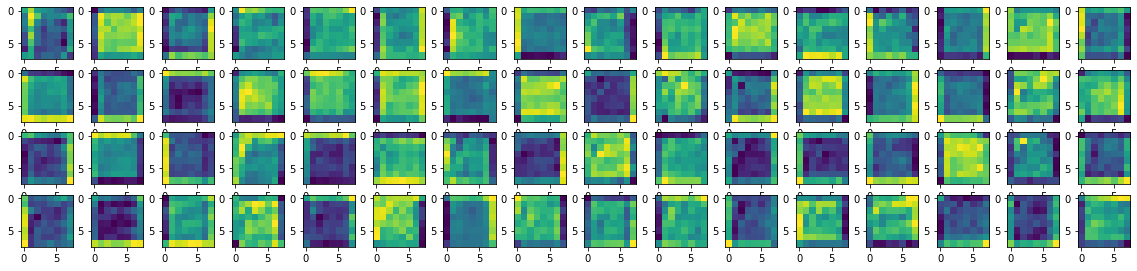

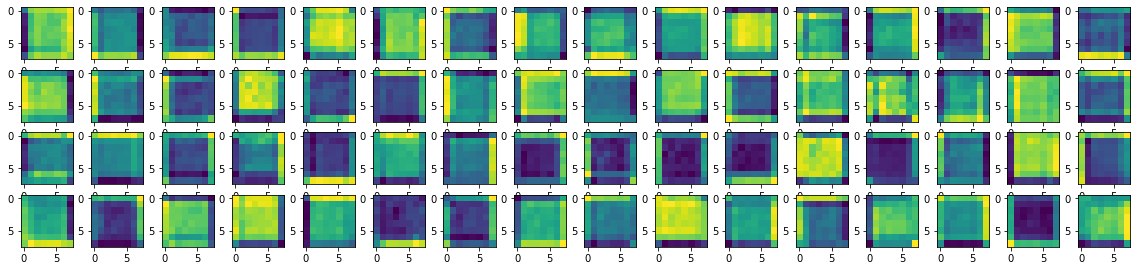

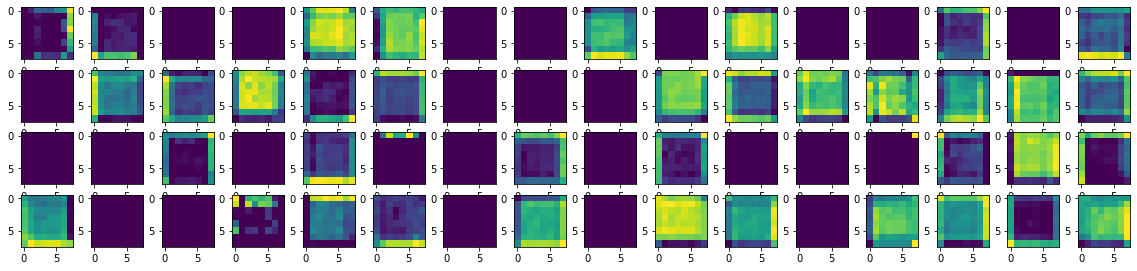

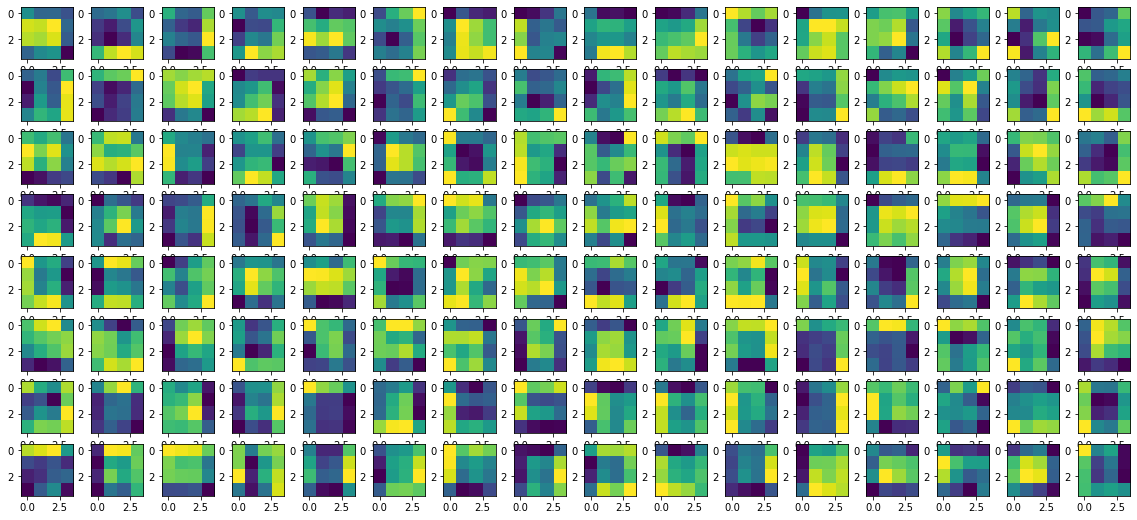

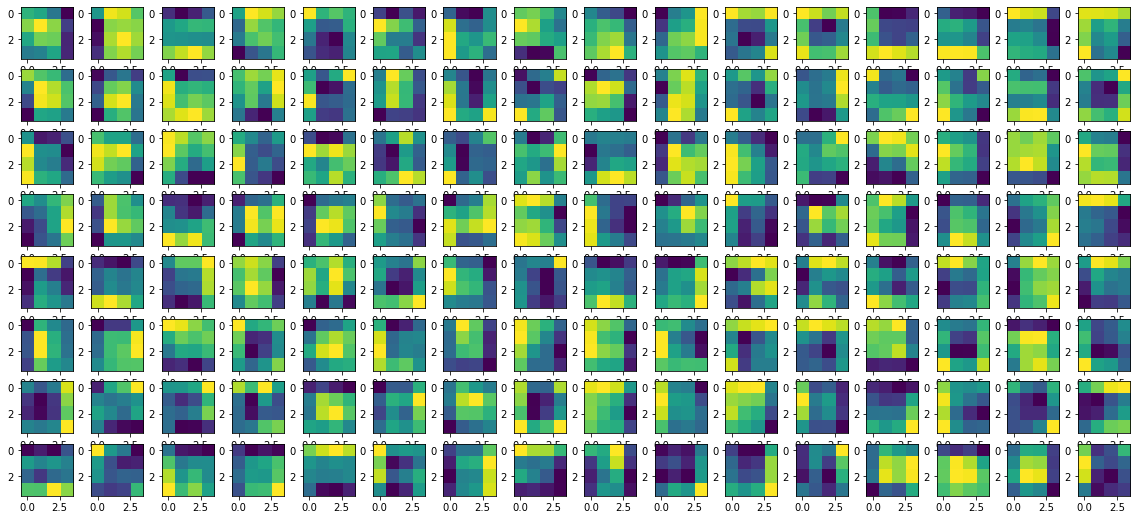

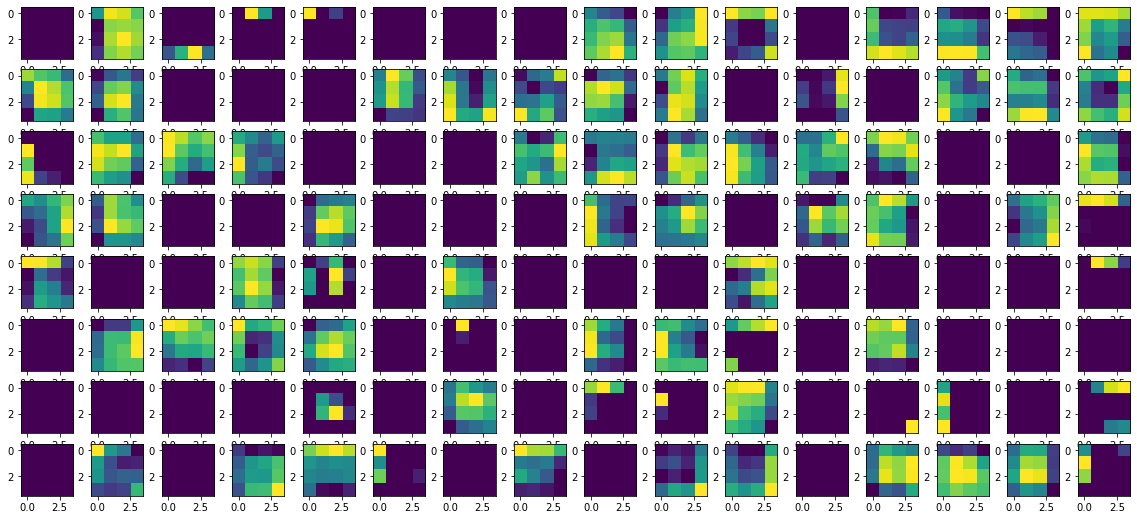

In [44]:
#Without normalize
for l in layers: 
    layer=x[l].detach().numpy()
    plt.figure(figsize=(20,9))
    for i,item in enumerate(layer[0]):
        plt.subplot(8, 16, i + 1)
        plt.imshow(layer[0,i,:,:])
    #plt.title('11111111111')

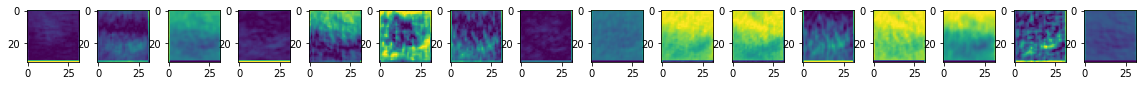

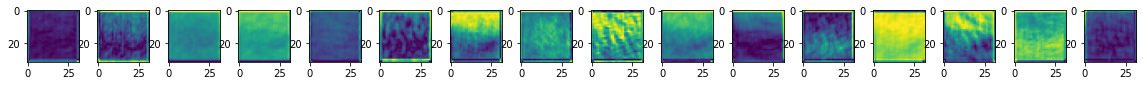

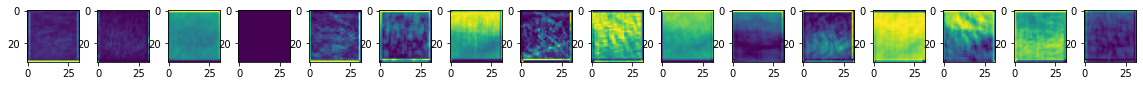

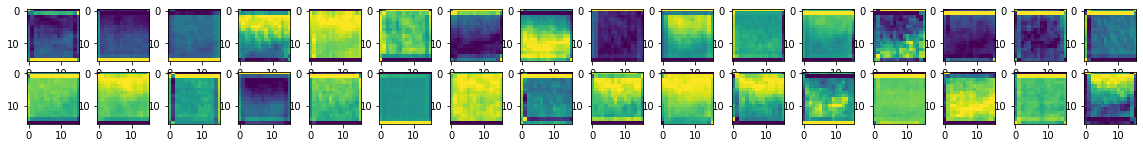

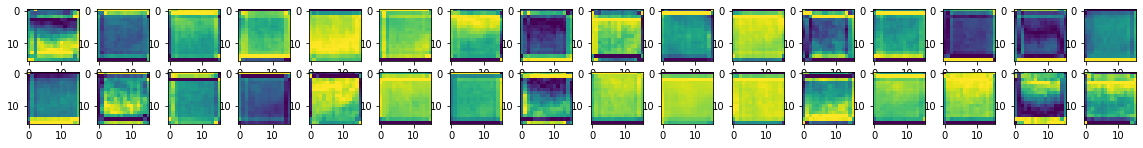

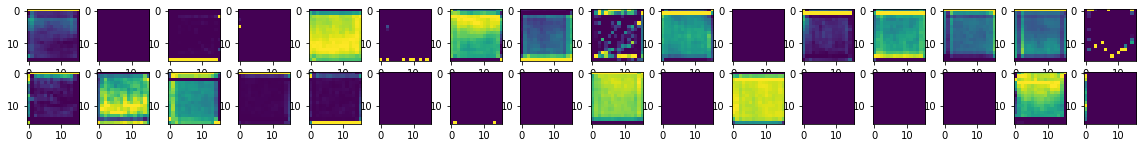

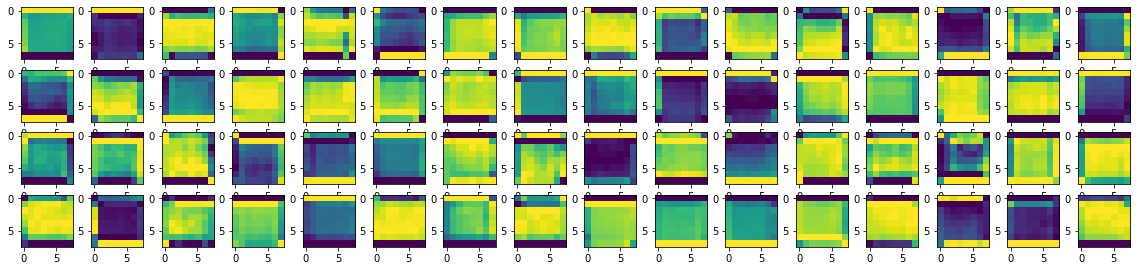

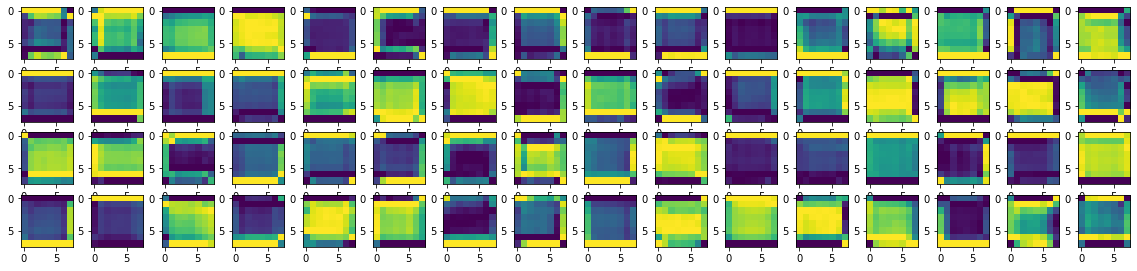

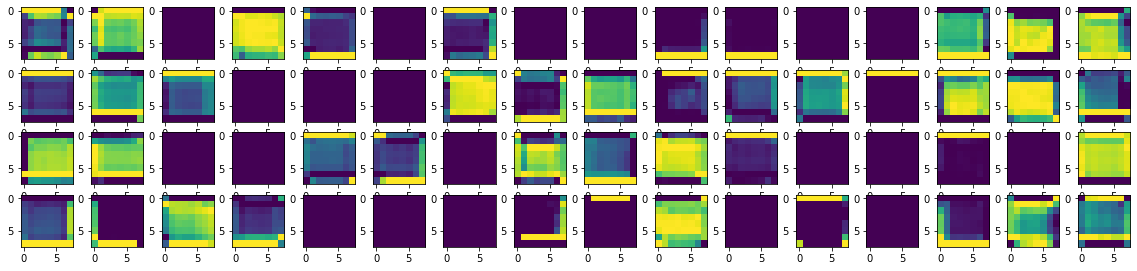

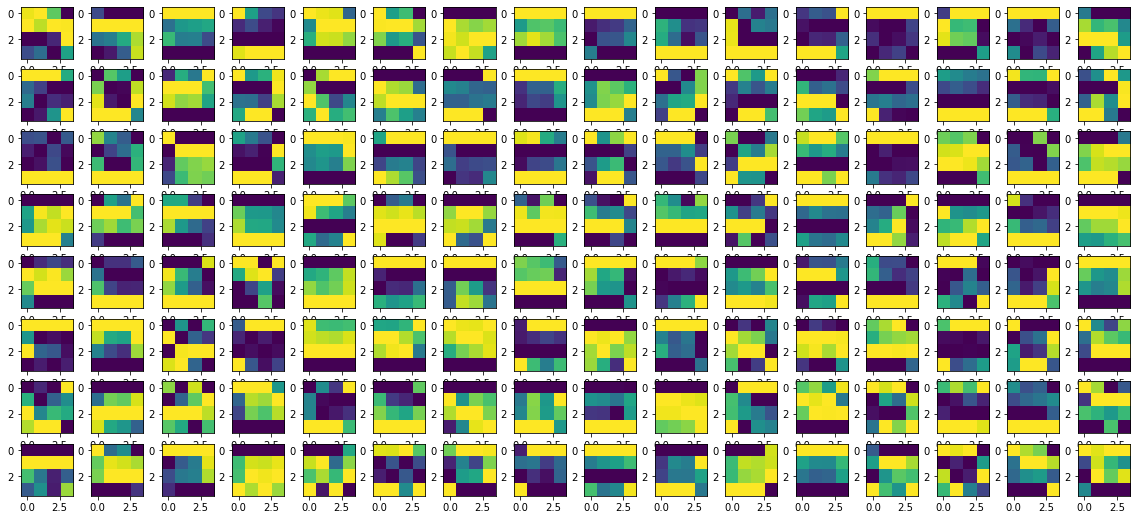

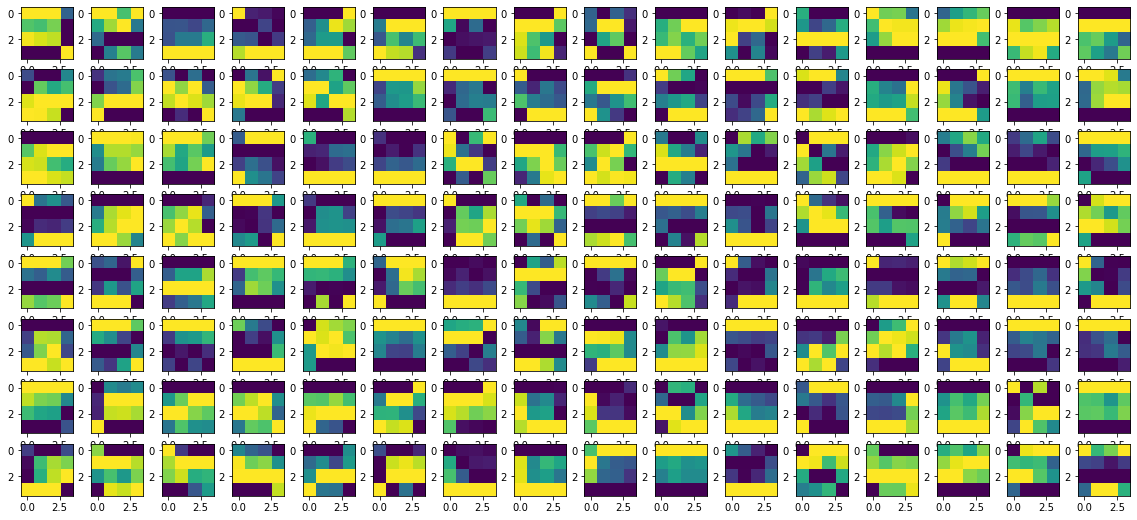

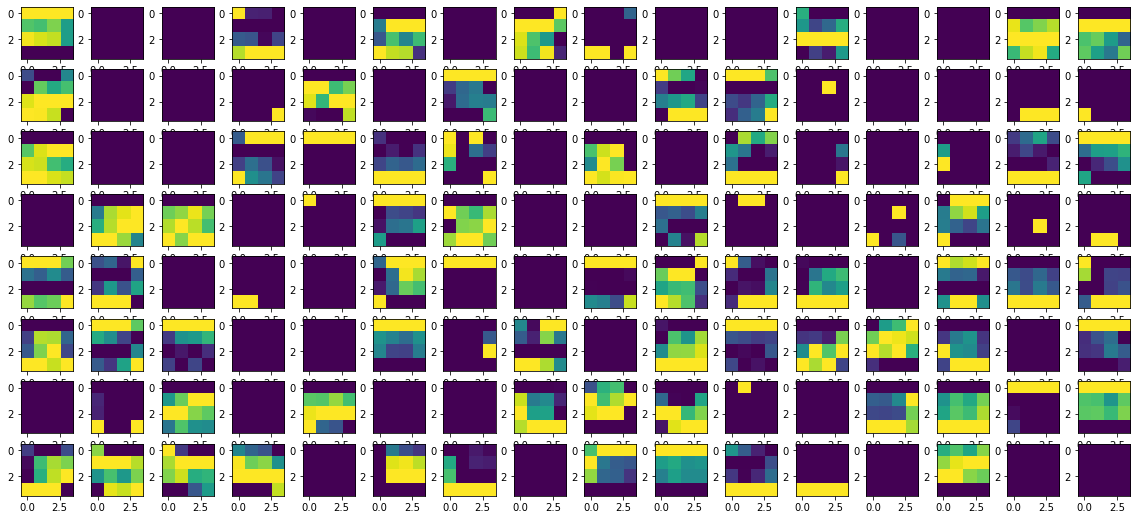

In [37]:
#Normalized
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
for l in layers: 
    layer=x[l].detach().numpy()
    #print(layer)
    layer_mean = np.expand_dims(np.abs(np.average(layer, axis = 0)), axis = 0)
    plt.figure(figsize=(20,9))
    for i,item in enumerate(layer_mean[0]):
        plt.subplot(8, 16, i + 1)
        normalized=scaler.fit_transform(layer_mean[0,i,:,:])
        #print(normalized)
        plt.imshow(normalized)
     #plt.title('11111111111')

In [64]:
abs_avgs = []    
for l in layers: 
    layer=x[l].detach().numpy()
    
    abs_avgs.append(np.abs(np.average(layer.flatten())))
abs_avgs

[0.040900663,
 0.020807259,
 0.047506265,
 0.0008069066,
 0.005299536,
 0.012740106,
 0.0030222693,
 0.0009854286,
 0.011189531,
 0.005824324,
 0.0004230837,
 0.008666078]